# Experimenting with Maximum Likelihood Parameter Estimation (MLE)
Ball drop air

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.integrate import odeint

## Generate data for a ball drop

In [2]:
def calculate_force(g, m, cd, u):
    return g*m - cd*u**2
    
def calculate_acceleration(g, cd, m, u):
    return calculate_force(g=g, m=m, cd=cd, u=u)/m

def ball_drop_air(states, t, g, m, cd):
    
    # states:
    # [x,u]
        
    x = states[0]
    u = states[1]
    dxdt = u
    
    dudt = calculate_acceleration(g=g, cd=cd, m=m, u=u)
    
    d_states_dt = np.array([dxdt,dudt])
    
    return d_states_dt

In [3]:
calculate_force(g=9.81, m=2,cd=0.01,u=5)

19.37

In [4]:
calculate_acceleration(g=9.81, m=2,cd=0.01,u=5)

9.685

In [5]:
def simulate(states_0, t, g, m, cd):
    states = odeint(func = ball_drop_air,y0 = states_0,t = t,args=(g,m,cd))
    return states

In [6]:
df_parameters = pd.DataFrame()
parameters_correct = {
    'g':9.81,
    'm':2,
    'cd':0.01,   
}
parameters_correct = pd.Series(data=parameters_correct, name='correct')
df_parameters = df_parameters.append(parameters_correct)

In [7]:
states_0 = np.array([0,0])
t = np.linspace(0,10,100)
g=9.81
m = 1
cd = 0.01
states = simulate(states_0=states_0,t = t, **parameters_correct)

In [8]:
x = states[:,0]
dxdt = states[:,1]

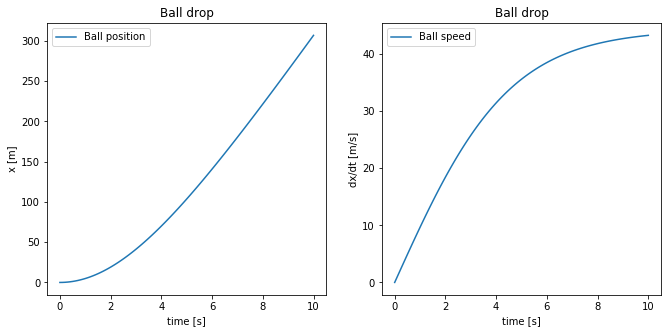

In [9]:
fig,axes = plt.subplots(ncols = 2)
fig.set_size_inches(11,5)
ax = axes[0]
ax.plot(t,x,label = 'Ball position')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
a = ax.legend()

ax = axes[1]
ax.plot(t,dxdt,label = 'Ball speed')

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('dx/dt [m/s]')
a = ax.legend()

## Ordinary Least Square fit (OLS)

## Add measurement noice

In [10]:
ϵ = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))
x_measure = x + ϵ

In [11]:
v_measure = np.gradient(x_measure,t)
a_measure = np.gradient(v_measure,t)

In [12]:
df = pd.DataFrame({'t':t, 'x':x, 'x_measure':x_measure, 'v':v_measure, 'a':a_measure})

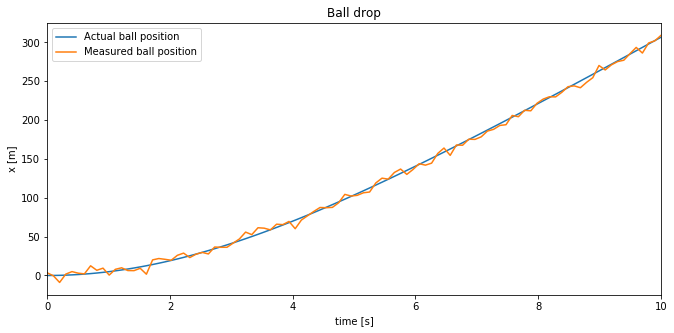

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)

df.plot(x='t', y='x', label = 'Actual ball position', ax=ax)
df.plot(x='t', y='x_measure', label = 'Measured ball position', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

In [14]:
from scipy.optimize import curve_fit
import inspect

In [15]:
def f(df,cd,g,m,a0,v0):
       
    states_0[0] = a0
    states_0[1] = v0
        
    states = simulate(states_0, t, g, m, cd)
    x = states[:,0]
    
    return x



In [16]:
def fit(f,df,ydata,p0):
    
    popt,pcov = curve_fit(f=f,xdata=df,ydata=ydata,p0=p0)
    
    signature = inspect.signature(f)
    parameter_names = list(signature.parameters.keys())[1:]
    
    parameter_values = list(popt)
    parameters = dict(zip(parameter_names, parameter_values))
    
    return parameters, pcov
    

In [18]:
signature = inspect.signature(f)
parameter_names = list(signature.parameters.keys())[1:]
    

guesses = {parameter_name:0 for parameter_name in parameter_names}
guesses['g'] = 9.8
guesses['m'] = 1
p0 = []
for parameter_name in parameter_names:
    p0.append(guesses[parameter_name])

In [19]:
parameters, pcov = fit(f=f, df=df, ydata=df['x'], p0=p0)
parameters = pd.Series(data=parameters,name='exact')
df_parameters = df_parameters.append(parameters)

c:\dev\rolldecay\venv\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [20]:
parameters_measure, pcov = fit(f=f, df=df, ydata=df['x_measure'], p0=p0)
parameters_measure = pd.Series(data=parameters_measure,name='measure')
df_parameters = df_parameters.append(parameters_measure)

In [21]:
results = df.copy()
results.drop(columns = ['x','x_measure'], inplace=True)

results['x'] = f(df=df,**parameters)
results['x_measure'] = f(df=df,**parameters_measure)


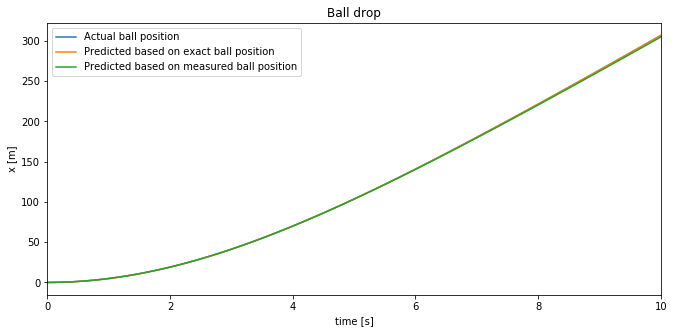

In [22]:
fig,ax = plt.subplots()
fig.set_size_inches(11,5)

df.plot(x='t', y='x', label = 'Actual ball position', ax=ax)
results.plot(x='t', y='x', label = 'Predicted based on exact ball position', ax=ax)
results.plot(x='t', y='x_measure', label = 'Predicted based on measured ball position', ax=ax)

ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]')
ax.legend()

In [23]:
df_parameters

,cd,g,m,a0,v0
correct,0.010000,9.810000,2.000000,NaN,NaN
exact,0.002516,9.810000,0.503211,0.0,0.0
measure,0.000966,9.837215,0.187942,0.0,0.0


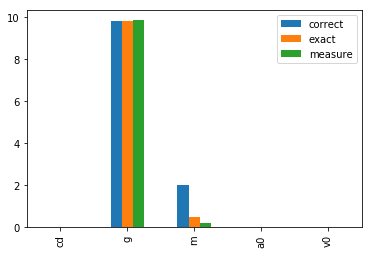

In [29]:
df_parameters.transpose().plot(kind='bar')